<a href="https://colab.research.google.com/github/ancestor9/Affalatoxin-Analysis/blob/main/prediction/0908_%EC%95%84%ED%94%8C%EB%9D%BC%ED%86%A1%EC%8B%A0_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_%EC%A1%B0%EC%83%81%EA%B5%AC_0909.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용된 기상항목
- tmprt_150	기온(150CM)
- tmprt_150Top	기온(150CM)최고
- tmprt_150Lwet	기온(150CM)최저
- hd_150	습도(150CM)
- arvlty_300	풍속(300CM)
- arvlty_300Top	최대풍속(300CM)
- afp	강수량
- sunshn_Time	일조시간
- solrad_Qy	일사량
- soil_Mitr_10	토양수분(10CM)

### 데이터 생성 방법
- 통합_LIMS에서 각 건에 대해 주소에 의해 (위도, 경도) 정보 api에서 조회
- 해당 주소가 없으면 상세 -> 넓은 범위로 넓혀가면서 조회
- 해당 (위도, 경도)와 가장 가까운 관측소를 찾아 해당일 기준 과거 30일 상기 기상항목을 record 형태로 만듦
- 혹시 필요할지 몰라 X에 이런 항목도 추가했음
    - INSPCT_PURPS_NAME
    - INSPCT_KND_NAME
    - PRDLST_NM
    - SPLORE_STTUS_NAME
    - ORGPLCE_NATION_CODE

### 데이터 읽는 방법
df_통합_LIMS_기상정보_결합_y = pd.read_pickle('../results/df_통합_LIMS_기상정보_결합_gzip_y.pkl', compression='gzip')
df_통합_LIMS_기상정보_결합_X = pd.read_pickle('../results/df_통합_LIMS_기상정보_결합_gzip_X.pkl', compression='gzip')

In [ ]:
# !pip install tensorflow -q

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install xgboost

In [2]:
import pandas as pd

def summarize(df):
    summary = pd.DataFrame(index=df.columns)
    summary['Data Type'] = df.dtypes
    summary['Unique Values'] = df.nunique()
    summary['Missing Values (%)'] = (df.isnull().sum() / len(df)) * 100

    # Get sample values, up to 10
    def get_sample_values(series):
        non_null_values = series.dropna().unique()
        if len(non_null_values) > 10:
            return non_null_values[:10].tolist()
        else:
            return non_null_values.tolist()

    # Collect sample values for each column
    sample_values_list = [get_sample_values(df[col]) for col in df.columns]
    summary['Sample Values'] = sample_values_list

    return summary

# **1. 데이터 수집 및 전처리**
### 상기실험확임함은 제거
### 가공식품 데이터만 분석대상으로

In [3]:
import pandas as pd
import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
# from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- 1단계: 데이터 로드 ---
X_df = pd.read_pickle('/content/drive/MyDrive/식약처/df_통합_LIMS_기상정보_결합_gzip_X.pkl', compression='gzip')
y_df = pd.read_pickle('/content/drive/MyDrive/식약처/df_통합_LIMS_기상정보_결합_gzip_y.pkl', compression='gzip')

In [4]:
# Filter out rows where 'JDGMNT_WORD_NAME' is '상기실험확인함'
filtered_indices_jdgmnt = y_df[y_df['JDGMNT_WORD_NAME'] != '상기실험확인함'].index

X_df_filtered = X_df.loc[filtered_indices_jdgmnt]
y_df_filtered = y_df.loc[filtered_indices_jdgmnt]['JDGMNT_WORD_NAME']

# Filter out rows where 'INSPCT_KND_NAME' is '축산물' from the already filtered dataframes
filtered_indices_knd = X_df_filtered[X_df_filtered['INSPCT_KND_NAME'] != '축산물'].index

X_df_filtered = X_df_filtered.loc[filtered_indices_knd]
y_df_filtered  = y_df_filtered.loc[filtered_indices_knd]

print("Filtered X_df shape after removing '상기실험확인함' and '축산물':", X_df_filtered.shape)
print("Filtered y_df shape after removing '상기실험확인함' and '축산물':", y_df_filtered.shape)

X_df_filtered.head()

Filtered X_df shape after removing '상기실험확인함' and '축산물': (130341, 305)
Filtered y_df shape after removing '상기실험확인함' and '축산물': (130341,)


,INSPCT_PURPS_NAME,INSPCT_KND_NAME,PRDLST_NM,SPLORE_STTUS_NAME,ORGPLCE_NATION_CODE,tmprt_150_29,tmprt_150Top_29,tmprt_150Lwet_29,hd_150_29,arvlty_300_29,...,tmprt_150_00,tmprt_150Top_00,tmprt_150Lwet_00,hd_150_00,arvlty_300_00,arvlty_300Top_00,afp_00,sunshn_Time_00,solrad_Qy_00,soil_Mitr_10_00
0,자가품질위탁검사,NaN,과자,냉동,NaN,-5.4,1.3,-10.6,59.3,0.3,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
1,자가품질위탁검사,NaN,과자,냉동,NaN,-5.4,1.3,-10.6,59.3,0.3,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
2,자가품질위탁검사,식품,보스웰리아추출물등 복합물(Flexir)(제2021-9호),실온,NaN,-2.6,3.0,-7.6,55.9,0.7,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
3,자가품질위탁검사,식품,보스웰리아추출물등 복합물(Flexir)(제2021-9호),실온,NaN,-2.6,3.0,-7.6,55.9,0.7,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
4,자가품질위탁검사,식품,과자,NaN,NaN,-1.8,2.7,-7.4,46.9,0.5,...,-2.5,4.4,-8.2,77.2,0.4,4.2,0.0,92.0,4.73,NaN


In [5]:
y_df_filtered.head()

,JDGMNT_WORD_NAME
0,적합
1,적합
2,적합
3,적합
4,적합


## 2. LIMS와 기후데이터는 원천과 데이터형태(timeseries, cross section data)이니 각각 분리하여 데이터 전처리 수행한다.

In [6]:
X_lims = X_df_filtered.loc[:, :'ORGPLCE_NATION_CODE']
X_weather = X_df_filtered.loc[:, 'tmprt_150_29':]

In [7]:
y_df_filtered.value_counts(normalize=True)*100

,proportion
JDGMNT_WORD_NAME,
적합,99.568823
부적합,0.431177


## 2.1. LIMS 데이터(Cross-sectional Data) 전처리

### **결론적으로 INSPCT_PURPS_NAME 이외는 모든 데이터가 필요없음**
### **다만 과제를 위해서 변수 2개(INSPCT_PURPS_NAME, PRDLST_NM)를 남김**

In [8]:
summarize(X_lims)

,Data Type,Unique Values,Missing Values (%),Sample Values
INSPCT_PURPS_NAME,object,5,0.000000,"[자가품질위탁검사, 수거검사, 품질검사, 기타, 모니터링검사]"
INSPCT_KND_NAME,object,1,20.745583,[식품]
PRDLST_NM,object,513,0.000000,"[과자, 보스웰리아추출물등 복합물(Flexir)(제2021-9호), 땅콩 또는 견과..."
SPLORE_STTUS_NAME,object,4,45.320352,"[냉동, 실온, 냉장, 완제품]"
ORGPLCE_NATION_CODE,object,23,99.693880,"[국산, 대한민국, 베트남, 한국, 중국, 2023-05-20, The United..."


In [9]:
# 결측률이 많은 변수는 제거
X_lims = X_lims.drop(columns=['INSPCT_KND_NAME', 'ORGPLCE_NATION_CODE', 'SPLORE_STTUS_NAME'])

print("X_lims shape after dropping specified columns:", X_lims.shape)
display(X_lims.head())

X_lims shape after dropping specified columns: (130341, 2)


,INSPCT_PURPS_NAME,PRDLST_NM
0,자가품질위탁검사,과자
1,자가품질위탁검사,과자
2,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호)
3,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호)
4,자가품질위탁검사,과자


In [10]:
# Filter PRDLST_NM values with length >= 10
X_df_filtered[X_df_filtered['PRDLST_NM'].str.len() >= 10]['PRDLST_NM'].value_counts()

,count
PRDLST_NM,
땅콩 또는 견과류가공품,42177
땅콩 또는 견과류 가공품,8270
나토균배양분말(제2013-6호),188
석류농축분말(제2018-8호),160
HK표고버섯균사체(제2010-35호),154
...,...
레몬버베나추출물 등 복합물(티에뜨레ⓡ)(제2022-13호),1
백편두추출분말(NOVAponin®)(제2024-6호),1
배초향·고지베리·무화과복합추출물(제2024-23호),1


### <font color='orange'> 식품의 종류가 동명이 많고 복합물이 유형으로 세부적으로 구분되어 추가적인 정리가 필요함. (식정원과 논의 필요)
- 땅콩 또는 견과류가공품, 땅콩 또는 견과류 가공품 --> 동일 식품유형임.
- 레몬버베나추출물 등 복합물(티에뜨레ⓡ)(제2022-13호) --> 이 건 ?
- 엑셀로 만들어 식정원에 전달 필요(mapping 해달라고)
- 본 분석에서는 value_count()가 50개 미만이면 기타로 grouping

In [ ]:
!pip install openpyxl -q

In [ ]:
# Get the index of the value counts (which are the unique PRDLST_NM values) and convert it to a Series
X_df_filtered['PRDLST_NM'].value_counts().index.to_series().to_excel('/content/drive/MyDrive/식약처/PRDLST_NM_value_counts.xlsx', index=False)

In [11]:
y_df_filtered.head()

,JDGMNT_WORD_NAME
0,적합
1,적합
2,적합
3,적합
4,적합


In [12]:
# Calculate value counts for PRDLST_NM
prdlst_nm_counts = X_lims['PRDLST_NM'].value_counts()

# Identify values with counts less than 10
low_frequency_values = prdlst_nm_counts[prdlst_nm_counts < 50].index

# Replace low frequency values with '기타_999'
X_lims['PRDLST_NM'] = X_lims['PRDLST_NM'].replace(low_frequency_values, '기타_999')

print("Updated value counts for 'PRDLST_NM' after grouping low frequency values:")
display(X_lims['PRDLST_NM'].value_counts())

Updated value counts for 'PRDLST_NM' after grouping low frequency values:


,count
PRDLST_NM,
땅콩 또는 견과류가공품,42177
과자,39826
땅콩 또는 견과류 가공품,8270
기타_999,4420
캔디류,3932
...,...
김치,54
가공치즈,52
비수리추출분말(제2022-40호),51


In [13]:
summarize(X_lims)

,Data Type,Unique Values,Missing Values (%),Sample Values
INSPCT_PURPS_NAME,object,5,0.0,"[자가품질위탁검사, 수거검사, 품질검사, 기타, 모니터링검사]"
PRDLST_NM,object,90,0.0,"[과자, 보스웰리아추출물등 복합물(Flexir)(제2021-9호), 땅콩 또는 견과..."


## 2.2. 기후 데이터(Time series data) 전처리

In [14]:
X_weather

,tmprt_150_29,tmprt_150Top_29,tmprt_150Lwet_29,hd_150_29,arvlty_300_29,arvlty_300Top_29,afp_29,sunshn_Time_29,solrad_Qy_29,soil_Mitr_10_29,...,tmprt_150_00,tmprt_150Top_00,tmprt_150Lwet_00,hd_150_00,arvlty_300_00,arvlty_300Top_00,afp_00,sunshn_Time_00,solrad_Qy_00,soil_Mitr_10_00
0,-5.4,1.3,-10.6,59.3,0.3,6.7,0.0,NaN,9.83,32.5,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
1,-5.4,1.3,-10.6,59.3,0.3,6.7,0.0,NaN,9.83,32.5,...,-4.8,1.9,-9.9,77.9,0.2,2.8,1.0,NaN,3.99,16.1
2,-2.6,3.0,-7.6,55.9,0.7,5.1,0.0,NaN,8.93,NaN,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
3,-2.6,3.0,-7.6,55.9,0.7,5.1,0.0,NaN,8.93,NaN,...,-2.9,5.7,-10.2,79.6,0.6,6.0,0.5,NaN,6.11,NaN
4,-1.8,2.7,-7.4,46.9,0.5,3.8,0.0,510.0,10.35,NaN,...,-2.5,4.4,-8.2,77.2,0.4,4.2,0.0,92.0,4.73,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170665,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7
170668,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7
170669,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7
170670,-2.1,5.2,-10.2,71.9,1.0,7.7,0.0,NaN,8.04,20.9,...,1.1,4.0,-0.3,97.1,0.2,2.6,11.0,NaN,3.14,21.7


- tmprt_150 기온(150CM)
- tmprt_150Top 기온(150CM)최고
- tmprt_150Lwet 기온(150CM)최저
- hd_150 습도(150CM)
- arvlty_300 풍속(300CM)
- arvlty_300Top 최대풍속(300CM)
- afp 강수량
- sunshn_Time 일조시간
- solrad_Qy 일사량
- soil_Mitr_10 토양수분(10CM)

### chatGPT
1. 기본 시계열 특성 (원천 데이터 그대로 활용)
- tmprt_150, tmprt_150Top, tmprt_150Lwet : 평균, 최대, 최소 기온 → 곰팡이 성장 가능성에 직접적인 영향
- hd_150 (습도) : 상대습도, 특히 장기간 높은 습도가 아플라톡신 발생의 주요 원인
- arvlty_300, arvlty_300Top (풍속) : 통풍 상태 반영 (풍속이 낮으면 곰팡이 번식 ↑)
- afp (강수량) : 토양 및 곡물의 수분 공급
- sunshn_Time, solrad_Qy (일조량/일사량) : 건조·살균 효과
- soil_Mitr_10 (토양수분) : 땅속 습도 → 작물 습기 유지 환경

<Axes: >

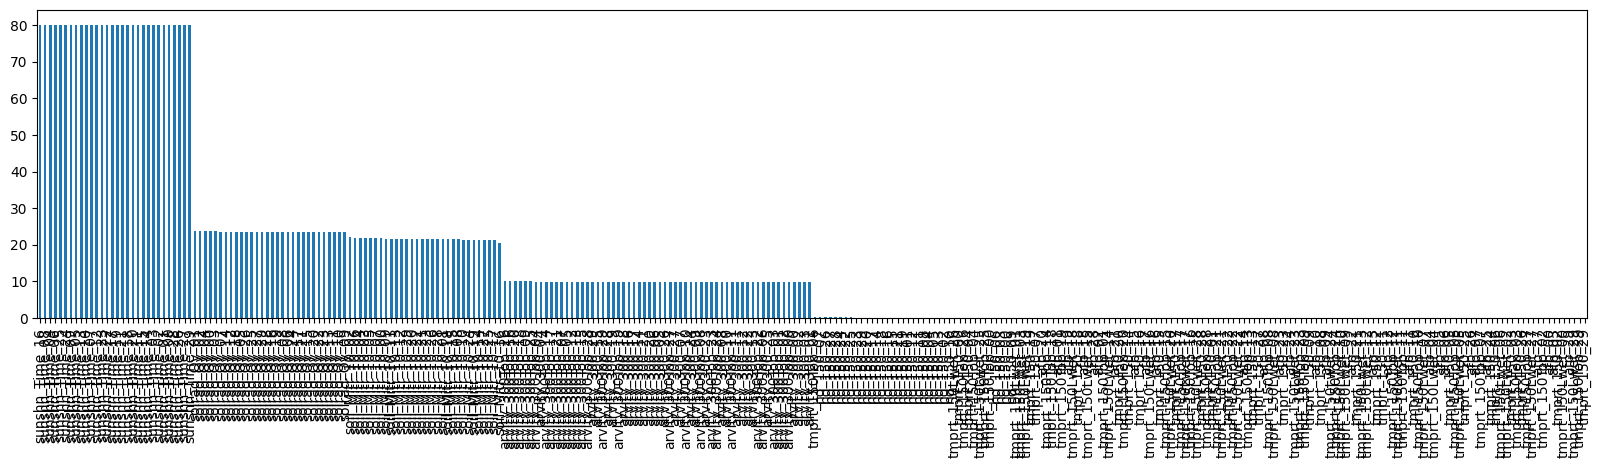

In [15]:
summarize(X_weather)['Missing Values (%)'].sort_values(ascending=False).plot(kind='bar', figsize=(20,4))

In [16]:
# Calculate missing value percentages for X_weather
missing_percentage_weather = X_weather.isnull().sum() / len(X_weather) * 100

# Identify columns with missing percentage >= 30% in X_weather
high_missing_cols = missing_percentage_weather[missing_percentage_weather >= 30]

print("Columns in X_weather with >= 30% missing values:")
display(high_missing_cols)

Columns in X_weather with >= 30% missing values:


,0
sunshn_Time_29,80.023937
sunshn_Time_28,80.023937
sunshn_Time_27,80.023937
sunshn_Time_26,80.023937
sunshn_Time_25,80.141322
sunshn_Time_24,80.141322
sunshn_Time_23,80.141322
sunshn_Time_22,80.141322
sunshn_Time_21,80.141322
sunshn_Time_20,80.141322


In [17]:
# Identify columns containing 'sunshn_Time'
sunshn_cols_to_drop = [col for col in X_weather.columns if 'sunshn_Time' in col]

# Drop these columns from X_weather
X_weather = X_weather.drop(columns=sunshn_cols_to_drop)

print(f"Dropped {len(sunshn_cols_to_drop)} columns containing 'sunshn_Time'.")
print("New X_weather shape:", X_weather.shape)

Dropped 30 columns containing 'sunshn_Time'.
New X_weather shape: (130341, 270)


In [18]:
summarize(X_weather)

,Data Type,Unique Values,Missing Values (%),Sample Values
tmprt_150_29,float64,245,0.029922,"[-5.4, -2.6, -1.8, -5.5, 0.2, -5.2, -3.3, -4.9..."
tmprt_150Top_29,float64,271,0.029922,"[1.3, 3.0, 2.7, 1.8, 7.6, 1.2, 2.0, 2.8, 7.7, ..."
tmprt_150Lwet_29,float64,252,0.029922,"[-10.6, -7.6, -7.4, -11.6, -5.7, -10.3, -8.8, ..."
hd_150_29,float64,449,0.108945,"[59.3, 55.9, 46.9, 62.1, 66.8, 65.9, 56.5, 67...."
arvlty_300_29,float64,47,9.935477,"[0.3, 0.7, 0.5, 0.2, 0.0, 0.4, 0.6, 0.9, 1.0, ..."
...,...,...,...,...
arvlty_300_00,float64,56,9.914762,"[0.2, 0.6, 0.4, 0.0, 0.3, 0.7, 1.5, 1.1, 0.8, ..."
arvlty_300Top_00,float64,165,9.915529,"[2.8, 6.0, 4.2, 0.0, 7.9, 3.6, 5.1, 7.1, 10.6,..."
afp_00,float64,34,0.032990,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
solrad_Qy_00,float64,791,23.676357,"[3.99, 6.11, 4.73, 9.52, 4.25, 4.23, 7.0, 13.5..."


In [19]:
# Get the summary of X_weather
summary_weather = summarize(X_weather)

# Sort the summary DataFrame by index (column names)
summary_weather_sorted = summary_weather.sort_index()

# Display the sorted summary
display(summary_weather_sorted)

,Data Type,Unique Values,Missing Values (%),Sample Values
afp_00,float64,34,0.032990,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
afp_01,float64,20,0.032990,"[1.0, 0.0, 0.5, 1.5, 5.0, 4.5, 4.0, 10.5, 9.5,..."
afp_02,float64,35,0.032990,"[0.0, 0.5, 1.0, 6.5, 3.5, 1.5, 2.0, 3.0, 2.5, ..."
afp_03,float64,55,0.032990,"[0.5, 0.0, 1.0, 1.5, 6.0, 2.5, 2.0, 5.0, 3.5, ..."
afp_04,float64,26,0.032990,"[0.5, 0.0, 1.5, 4.0, 2.5, 1.0, 2.0, 3.5, 3.0, ..."
...,...,...,...,...
tmprt_150_25,float64,238,0.032990,"[-2.8, 0.1, 0.0, -2.3, 0.4, -4.0, -0.3, -2.4, ..."
tmprt_150_26,float64,233,0.032990,"[-4.6, -2.9, -2.4, -4.8, -1.2, -4.4, -3.4, 3.3..."
tmprt_150_27,float64,238,0.032990,"[-3.4, -2.0, -1.8, -4.0, 1.8, -2.4, -2.3, -1.5..."
tmprt_150_28,float64,240,0.032990,"[0.2, 3.1, 3.3, 1.0, 3.2, -1.4, 0.0, 5.8, 4.8,..."


### 시계열자료 채우기 시간순으로

In [20]:
# 소팅을 해서 컬럼명이 텍스트가 같은 그룹내에서 날짜순으로 앞뒤로 채우려고
X_weather = X_weather.sort_index(axis=1)
X_weather.head()

,afp_00,afp_01,afp_02,afp_03,afp_04,afp_05,afp_06,afp_07,afp_08,afp_09,...,tmprt_150_20,tmprt_150_21,tmprt_150_22,tmprt_150_23,tmprt_150_24,tmprt_150_25,tmprt_150_26,tmprt_150_27,tmprt_150_28,tmprt_150_29
0,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,-1.5,-1.1,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4
1,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,-1.5,-1.1,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.8,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.8,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6
4,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,...,1.6,1.4,3.4,2.1,4.1,0.0,-2.4,-1.8,3.3,-1.8


In [21]:
import re

def fix_nan_auto_group(df):

    '''
    시계열자료 채우기 로직
    '''
    result = df.copy()

    # 컬럼 이름에서 그룹 접두사(e.g., 'wtf', 'vsf')를 자동으로 추출
    # '_01' 과 같은 부분을 제외하고 고유한 그룹 이름을 찾음
    groups = {re.findall(r'(\w+)_', col)[0] for col in df.columns if '_' in col}

    # 각 그룹별로 NaN 값 채우기
    for group_name in groups:
        group_cols = [col for col in df.columns if col.startswith(group_name)]
        # 그룹 내에서 뒤쪽 값으로 먼저 채운 후 앞쪽 값으로 채우기
        result[group_cols] = result[group_cols].bfill(axis=1).ffill(axis=1)

    # 그룹 내에서 채워지지 않은 NaN(행의 양끝)을 0으로 채우기
    result = result.fillna(0)

    return result

In [22]:
X_weather = fix_nan_auto_group(X_weather)

In [23]:
X_weather.isnull().sum().sum() # 결측치 없음

np.int64(0)

In [24]:
summarize(X_weather)

,Data Type,Unique Values,Missing Values (%),Sample Values
afp_00,float64,34,0.0,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
afp_01,float64,20,0.0,"[1.0, 0.0, 0.5, 1.5, 5.0, 4.5, 4.0, 10.5, 9.5,..."
afp_02,float64,35,0.0,"[0.0, 0.5, 1.0, 6.5, 3.5, 1.5, 2.0, 3.0, 2.5, ..."
afp_03,float64,55,0.0,"[0.5, 0.0, 1.0, 1.5, 6.0, 2.5, 2.0, 5.0, 3.5, ..."
afp_04,float64,26,0.0,"[0.5, 0.0, 1.5, 4.0, 2.5, 1.0, 2.0, 3.5, 3.0, ..."
...,...,...,...,...
tmprt_150_25,float64,239,0.0,"[-2.8, 0.1, 0.0, -2.3, 0.4, -4.0, -0.3, -2.4, ..."
tmprt_150_26,float64,233,0.0,"[-4.6, -2.9, -2.4, -4.8, -1.2, -4.4, -3.4, 3.3..."
tmprt_150_27,float64,238,0.0,"[-3.4, -2.0, -1.8, -4.0, 1.8, -2.4, -2.3, -1.5..."
tmprt_150_28,float64,241,0.0,"[0.2, 3.1, 3.3, 1.0, 3.2, -1.4, 0.0, 5.8, 4.8,..."


### 입력데이터 정리

In [25]:
# Merge X_weather and X_lims based on their index
X = pd.concat([X_weather, X_lims], axis=1)
print("Shape of the combined DataFrame (X_combined):", X.shape)

Shape of the combined DataFrame (X_combined): (130341, 272)


In [26]:
y = y_df_filtered.copy()
print("Shape of target:", y.shape)

Shape of target: (130341,)


In [27]:
summarize(X)

,Data Type,Unique Values,Missing Values (%),Sample Values
afp_00,float64,34,0.0,"[1.0, 0.5, 0.0, 2.0, 7.0, 2.5, 10.5, 16.5, 8.5..."
afp_01,float64,20,0.0,"[1.0, 0.0, 0.5, 1.5, 5.0, 4.5, 4.0, 10.5, 9.5,..."
afp_02,float64,35,0.0,"[0.0, 0.5, 1.0, 6.5, 3.5, 1.5, 2.0, 3.0, 2.5, ..."
afp_03,float64,55,0.0,"[0.5, 0.0, 1.0, 1.5, 6.0, 2.5, 2.0, 5.0, 3.5, ..."
afp_04,float64,26,0.0,"[0.5, 0.0, 1.5, 4.0, 2.5, 1.0, 2.0, 3.5, 3.0, ..."
...,...,...,...,...
tmprt_150_27,float64,238,0.0,"[-3.4, -2.0, -1.8, -4.0, 1.8, -2.4, -2.3, -1.5..."
tmprt_150_28,float64,241,0.0,"[0.2, 3.1, 3.3, 1.0, 3.2, -1.4, 0.0, 5.8, 4.8,..."
tmprt_150_29,float64,245,0.0,"[-5.4, -2.6, -1.8, -5.5, 0.2, -5.2, -3.3, -4.9..."
INSPCT_PURPS_NAME,object,5,0.0,"[자가품질위탁검사, 수거검사, 품질검사, 기타, 모니터링검사]"


In [32]:
# Merge X and y based on their index
# Using pd.concat with axis=1 assumes both dataframes have the same index
merged_df = pd.concat([X, y], axis=1)
merged_df.columns

Index(['afp_00', 'afp_01', 'afp_02', 'afp_03', 'afp_04', 'afp_05', 'afp_06',
       'afp_07', 'afp_08', 'afp_09',
       ...
       'tmprt_150_23', 'tmprt_150_24', 'tmprt_150_25', 'tmprt_150_26',
       'tmprt_150_27', 'tmprt_150_28', 'tmprt_150_29', 'INSPCT_PURPS_NAME',
       'PRDLST_NM', 'JDGMNT_WORD_NAME'],
      dtype='object', length=273)

In [34]:
# Encode 'JDGMNT_WORD_NAME': 부적합=1, 적합=0
merged_df['JDGMNT_WORD_NAME_encoded'] = merged_df['JDGMNT_WORD_NAME'].map({'부적합': 1, '적합': 0})

print("Value counts for the new encoded 'JDGMNT_WORD_NAME_encoded' column:")
display(merged_df['JDGMNT_WORD_NAME_encoded'].value_counts())

print("\nFirst few rows of merged_df with the new encoded column:")
display(merged_df.head())

Value counts for the new encoded 'JDGMNT_WORD_NAME_encoded' column:


,count
JDGMNT_WORD_NAME_encoded,
0,129779
1,562



First few rows of merged_df with the new encoded column:


,afp_00,afp_01,afp_02,afp_03,afp_04,afp_05,afp_06,afp_07,afp_08,afp_09,...,tmprt_150_24,tmprt_150_25,tmprt_150_26,tmprt_150_27,tmprt_150_28,tmprt_150_29,INSPCT_PURPS_NAME,PRDLST_NM,JDGMNT_WORD_NAME,JDGMNT_WORD_NAME_encoded
0,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,2.0,-2.8,-4.6,-3.4,0.2,-5.4,자가품질위탁검사,과자,적합,0
1,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,2.0,-2.8,-4.6,-3.4,0.2,-5.4,자가품질위탁검사,과자,적합,0
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.1,-2.9,-2.0,3.1,-2.6,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),적합,0
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.1,-2.9,-2.0,3.1,-2.6,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호),적합,0
4,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,...,4.1,0.0,-2.4,-1.8,3.3,-1.8,자가품질위탁검사,과자,적합,0


### 부적합 비율이 있는 검사의 종류

In [30]:
# Calculate the mean of JDGMNT_WORD_NAME_encoded, grouped by INSPCT_PURPS_NAME
grouped_mean_by_purpose = merged_df.groupby('INSPCT_PURPS_NAME')['JDGMNT_WORD_NAME_encoded'].mean()

print("Mean of encoded 'JDGMNT_WORD_NAME' by 'INSPCT_PURPS_NAME' (proportion of '부적합'):")
display(grouped_mean_by_purpose)

Mean of encoded 'JDGMNT_WORD_NAME' by 'INSPCT_PURPS_NAME' (proportion of '부적합'):


,JDGMNT_WORD_NAME_encoded
INSPCT_PURPS_NAME,
기타,0.013845
모니터링검사,0.000000
수거검사,0.006504
자가품질위탁검사,0.003874
품질검사,0.000000


### 부적합 비율이 있는 가공식품의 종류 (상위분류면이 필요)

In [31]:
# Calculate the mean of the encoded JDGMNT_WORD_NAME, grouped by PRDLST_NM
grouped_mean_by_prdlst = merged_df.groupby('PRDLST_NM')['JDGMNT_WORD_NAME_encoded'].mean()
# Filter the series to show only the rows where the mean is greater than 0
prdlst_with_failures = grouped_mean_by_prdlst[grouped_mean_by_prdlst > 0]
print("Product Names (PRDLST_NM) with at least one '부적합' case:")
display(prdlst_with_failures)

Product Names (PRDLST_NM) with at least one '부적합' case:


,JDGMNT_WORD_NAME_encoded
PRDLST_NM,
강황추출물(제2023-5호),0.022222
고춧가루,0.012480
곡류가공품,0.007215
과.채가공품,0.002081
과자,0.007432
기타_999,0.004751
기타가공품,0.001529
두류가공품,0.002466
땅콩 또는 견과류 가공품,0.001814


# **2. 예측모형 개발**
### 전처리한(특성변수 추출은 없음) 데이터를 예측모형에 투입
### 2.1. Features and Target

In [36]:
merged_df.columns

Index(['afp_00', 'afp_01', 'afp_02', 'afp_03', 'afp_04', 'afp_05', 'afp_06',
       'afp_07', 'afp_08', 'afp_09',
       ...
       'tmprt_150_24', 'tmprt_150_25', 'tmprt_150_26', 'tmprt_150_27',
       'tmprt_150_28', 'tmprt_150_29', 'INSPCT_PURPS_NAME', 'PRDLST_NM',
       'JDGMNT_WORD_NAME', 'JDGMNT_WORD_NAME_encoded'],
      dtype='object', length=274)

In [37]:
# Create the feature matrix X by dropping the specified columns
X = merged_df.drop(columns=['JDGMNT_WORD_NAME', 'JDGMNT_WORD_NAME_encoded'])

# Create the target variable y using the encoded column
y = merged_df['JDGMNT_WORD_NAME_encoded']

print("Shape of feature matrix (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of feature matrix (X): (130341, 272)
Shape of target variable (y): (130341,)


In [38]:
X

,afp_00,afp_01,afp_02,afp_03,afp_04,afp_05,afp_06,afp_07,afp_08,afp_09,...,tmprt_150_22,tmprt_150_23,tmprt_150_24,tmprt_150_25,tmprt_150_26,tmprt_150_27,tmprt_150_28,tmprt_150_29,INSPCT_PURPS_NAME,PRDLST_NM
0,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4,자가품질위탁검사,과자
1,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4,자가품질위탁검사,과자
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호)
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6,자가품질위탁검사,보스웰리아추출물등 복합물(Flexir)(제2021-9호)
4,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,...,3.4,2.1,4.1,0.0,-2.4,-1.8,3.3,-1.8,자가품질위탁검사,과자
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170665,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,12.6,7.5,3.5,1.0,1.2,-2.2,-1.4,-2.1,모니터링검사,옥수수건조
170668,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,12.6,7.5,3.5,1.0,1.2,-2.2,-1.4,-2.1,모니터링검사,옥수수건조
170669,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,12.6,7.5,3.5,1.0,1.2,-2.2,-1.4,-2.1,모니터링검사,옥수수건조
170670,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,12.6,7.5,3.5,1.0,1.2,-2.2,-1.4,-2.1,모니터링검사,옥수수건조


### 2.2. 파이프라인 구성
데이터 전처리, 샘플링, 모델링 단계를 하나의 파이프라인으로 묶습니다.

1. 전처리 단계 (ColumnTransformer):

수치형 변수: StandardScaler를 적용해 스케일링합니다.

범주형 변수: OneHotEncoder를 적용해 원-핫 인코딩합니다.

2. 샘플링 단계:

SMOTE를 사용해 소수 클래스 데이터의 수를 늘려줍니다. imblearn의 Pipeline은 이 과정이 교차 검증 중 각 훈련 폴드에만 적용되도록 해줍니다.

3. 모델링 단계:

XGBClassifier를 사용합니다.

In [39]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

In [40]:
# 변수 유형 분리
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 전처리 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# 전체 파이프라인 구성 (imblearn.pipeline 사용)
# SMOTE는 훈련 데이터에만 적용되어야 하므로, imblearn의 Pipeline을 사용해야 합니다.
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

### 2.3. 하이퍼파라미터 튜닝 및 교차 검증
GridSearchCV를 사용해 정의된 파라미터 그리드에 따라 최적의 하이퍼파라미터를 찾고, 교차 검증을 수행합니다.

1. 하이퍼파라미터 그리드 정의:

튜닝할 XGBClassifier의 파라미터를 딕셔너리 형태로 정의합니다. 파이프라인 객체 내 모델 이름(classifier)과 파라미터 이름을 함께 사용합니다.

2. 교차 검증 (StratifiedKFold):

불균형 데이터셋의 경우 StratifiedKFold를 사용해 타겟 클래스의 비율을 유지하며 데이터를 나눕니다.

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
# 하이퍼파라미터 분포 정의
# GridSearchCV의 리스트 대신, 분포 함수를 사용해 더 넓은 범위의 탐색이 가능합니다.
param_distributions = {
    'classifier__n_estimators': randint(100, 500), # 100에서 500 사이의 정수
    'classifier__learning_rate': uniform(0.01, 0.2), # 0.01에서 0.2 사이의 실수
    'classifier__max_depth': randint(3, 10), # 3에서 10 사이의 정수
    'classifier__subsample': uniform(0.6, 0.4), # 0.6에서 1.0 사이의 실수
}

param_distributions = {}  # 너무 오래 걸려 파라미터 없이

# 교차 검증 설정 (이전과 동일)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=50, # 탐색할 무작위 샘플링 횟수
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1,
    random_state=42 # 재현성을 위해 시드 설정
)

# 튜닝 시작
print("Starting RandomizedSearchCV for hyperparameter tuning...")
random_search.fit(X, y)
print("RandomizedSearchCV completed.")

Starting RandomizedSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
RandomizedSearchCV completed.


### 2.3. 결과 확인
튜닝이 완료된 후, 최적의 하이퍼파라미터와 교차 검증 결과를 확인합니다.

In [50]:
random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['afp_00', 'afp_01', 'afp_02', 'afp_03', 'afp_04', 'afp_05', 'afp_06',
       'afp_07', 'afp_08', 'afp_09',
       ...
       'tmprt_150_20', 'tmprt_150_21', 'tmprt_150_22', 'tmprt_150_23',
       'tmprt_150_24', 'tmprt_150_25', 'tmprt_150_26', 'tmprt_150_27',
       'tmprt_150_28', 'tm...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [56]:
random_search.best_params_

{}

Classification Report for the Best Estimator:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     25957
           1       0.05      0.83      0.10       112

    accuracy                           0.93     26069
   macro avg       0.52      0.88      0.53     26069
weighted avg       1.00      0.93      0.96     26069


Confusion Matrix for the Best Estimator:
[[24209  1748]
 [   19    93]]


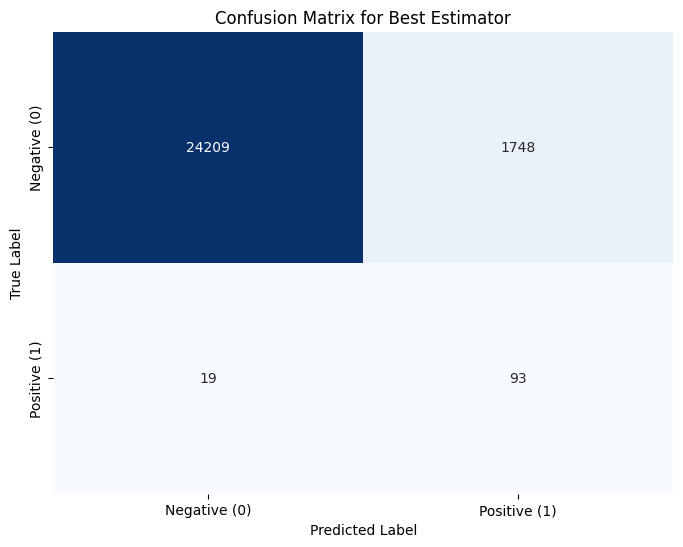

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np

# Assuming X and y are available from previous cells
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # Use the original y for stratification
)

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define and fit the RandomizedSearchCV pipeline here
# Define numerical and categorical features (Assuming X is the combined dataframe)
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Handle unknown categories
    ],
    remainder='passthrough'
)

# Full pipeline with SMOTE and Classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Hyperparameter distribution (using the empty dict as previously set)
param_distributions = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV object creation
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=1, # Set n_iter to 1 since param_distributions is empty
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit RandomizedSearchCV
print("Starting RandomizedSearchCV for hyperparameter tuning...")
random_search.fit(X, y)
print("RandomizedSearchCV completed.")


# Get the best estimator from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report for the Best Estimator:")
print(classification_report(y_test_encoded, y_pred_best))

# Calculate and visualize confusion matrix
conf_matrix_best = confusion_matrix(y_test_encoded, y_pred_best)

print("\nConfusion Matrix for the Best Estimator:")
print(conf_matrix_best)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['적합 (0)', '부적합 (1)'], yticklabels=['적합 (0)', '부적합 (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best Estimator')
plt.show()

# Calculate ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test_encoded, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Estimator')
plt.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_encoded, y_pred_proba_best)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Best Estimator')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.show()

# Plot predicted probabilities vs. true labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_proba_best, y=np.random.rand(len(y_pred_proba_best)) * 0.1 + y_test_encoded, hue=y_test_encoded, alpha=0.6, s=10)
plt.xlabel('Predicted Probability of Positive Class (1)')
plt.ylabel('True Label (0 or 1)')
plt.title('Predicted Probability vs. True Label')
plt.yticks([0, 1], ['적합 (0)', '부적합 (1)'])
plt.grid(axis='y', linestyle='--')
plt.show()

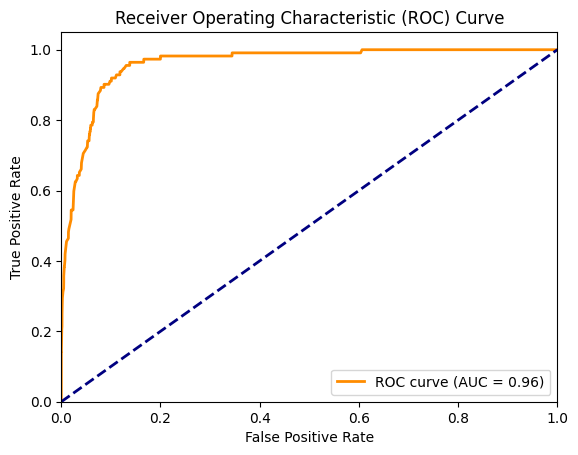

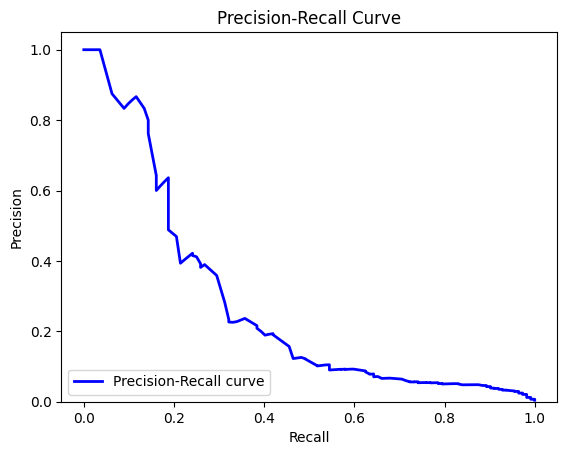

In [68]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Assuming y_test_encoded and y_pred_proba_best are available from previous cells

# Calculate ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)

# Plot Precision-Recall curve
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.show()

In [69]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Assuming y_test_encoded and y_pred_best are available from previous cells

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_best)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Calculate Cohen's Kappa score
kappa = cohen_kappa_score(y_test, y_pred_best)
print(f"Cohen's Kappa Score: {kappa:.4f}")

Matthews Correlation Coefficient (MCC): 0.1948
Cohen's Kappa Score: 0.0878


In [76]:
from sklearn.metrics import precision_recall_curve

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_best)
scores = [np.sum(to_labels(y_pred_proba_best, t))/len(y_pred_proba_best) for t in thresholds]

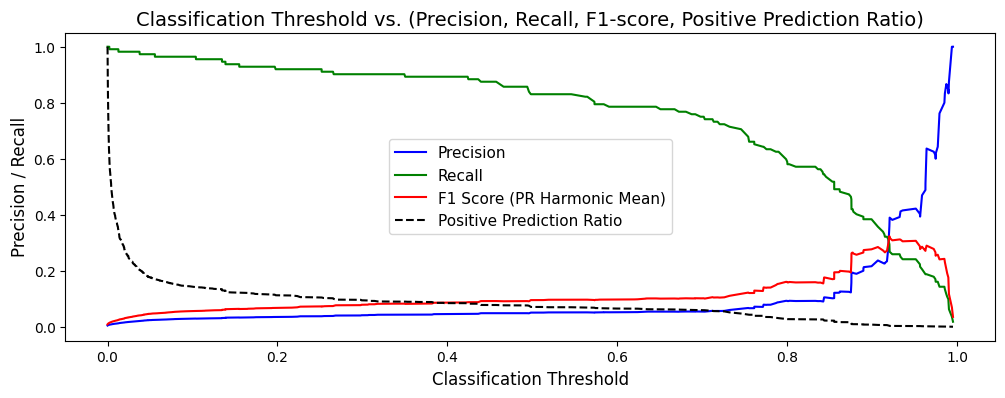

In [80]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, scores):
    plt.rcParams["figure.figsize"] = (12, 4)
    # The font family setting is removed as it's specific to Korean characters.

    plt.title('Classification Threshold vs. (Precision, Recall, F1-score, Positive Prediction Ratio)', fontsize='14')
    plt.plot(thresholds, precisions[:-1], 'b-', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.plot(thresholds, (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1]),
             'r-', label='F1 Score (PR Harmonic Mean)')
    plt.plot(thresholds, scores, 'k--', label='Positive Prediction Ratio')
    plt.ylabel('Precision / Recall', fontsize='12')
    plt.xlabel('Classification Threshold', fontsize='12')
    plt.legend(loc='best', fontsize='11')

# Example usage (assuming precisions, recalls, thresholds, and scores are defined)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, scores)

## **3. Pycaret**

In [70]:
# Drop the 'JDGMNT_WORD_NAME' column
merged_df_no_original_target = merged_df.drop(columns=['JDGMNT_WORD_NAME'])

# Save the modified DataFrame to a pickle file
merged_df_no_original_target.to_pickle('/content/drive/MyDrive/식약처/merged_df_no_original_target_pickle.pkl')

print("Dropped 'JDGMNT_WORD_NAME' column and saved the modified DataFrame to 'merged_df_no_original_target_pickle.pkl'")

Dropped 'JDGMNT_WORD_NAME' column and saved the modified DataFrame to 'merged_df_no_original_target_pickle.pkl'


### 천영진 코드

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import numpy as np
from scipy.sparse import hstack

# 1. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify= y_df_filtered
)

# 2. 타겟 변수 인코딩
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
# print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# 3. 범주형 피처 인코딩 (희소행렬로 변환) - Use original X_train for fitting
object_cols = X_train.select_dtypes(include='object').columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

X_train_encoded_ohe = ohe.fit_transform(X_train[object_cols]) # Fit on original X_train
X_test_encoded_ohe = ohe.transform(X_test[object_cols]) # Transform X_test

# 수치형 피처는 그대로 유지
numeric_cols = X_train.drop(columns=object_cols).columns
X_train_numeric = X_train[numeric_cols].values
X_test_numeric = X_test[numeric_cols].values

# 범주형 + 수치형 합치기 (희소행렬)
X_train_all = hstack([X_train_encoded_ohe, X_train_numeric])
X_test_all = hstack([X_test_encoded_ohe, X_test_numeric])


# 4. 결측치 처리 (SimpleImputer → 빠름) - Impute combined data
imputer = SimpleImputer(strategy="most_frequent")
X_train_imputed = imputer.fit_transform(X_train_all.toarray())
X_test_imputed = imputer.transform(X_test_all.toarray())

# 5. SMOTE 적용 (소수 클래스만 오버샘플링) - Apply SMOTE after imputation
print("\nBefore SMOTE:")
print(pd.Series(y_train_encoded).value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train_encoded) # Use imputed and encoded data

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# 6. 최종 데이터셋 크기 확인
print("\n--- Final Shapes for Model Training ---")
print("Shape of X_train_resampled:", X_train_resampled.shape)
print("Shape of X_test_imputed:", X_test_imputed.shape)
print("Shape of y_train_resampled:", y_train_resampled.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)

# 학습

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# -----------------------------
# 1. 타겟 변수 인코딩 (이미 SMOTE 적용 전 데이터 사용)
# -----------------------------
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("\nClass mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# -----------------------------
# 2. XGBoost 모델 초기화
# -----------------------------
# SMOTE 적용 후 이미 클래스 균형이 맞춰졌으므로 scale_pos_weight 제거
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,  # 최신 버전에서 deprecated warning 방지
    random_state=42
)

# -----------------------------
# 3. SMOTE 적용 후 데이터로 학습
# -----------------------------
print("\nRetraining XGBoost Classifier with SMOTE-resampled data...")
xgb_classifier.fit(X_train_resampled, y_train_resampled)
print("Training complete.")

# -----------------------------
# 4. 예측 및 평가
# -----------------------------
# X_test_imputed를 그대로 사용
y_pred_class = xgb_classifier.predict(X_test_imputed)
y_pred_proba = xgb_classifier.predict_proba(X_test_imputed)[:, 1]

accuracy = accuracy_score(y_test_encoded, y_pred_class)
precision = precision_score(y_test_encoded, y_pred_class)
recall = recall_score(y_test_encoded, y_pred_class)
f1 = f1_score(y_test_encoded, y_pred_class)

print(f"\nClassifier Performance Metrics (after SMOTE + XGBoost):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test_encoded, y_pred_class)
print("\nConfusion Matrix (after SMOTE + XGBoost):")
print(conf_matrix)

roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print(f"\nROC-AUC Score (after SMOTE + XGBoost): {roc_auc:.4f}")
